# OLID (Offensive Language Identification Dataset)
Predicting the Type and Target of Offensive Posts in Social Media

## Import Libraries

In [1]:
import pandas as pd
import string
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.corpus import stopwords as st
import random
import pickle
from warnings import filterwarnings
filterwarnings("ignore")

## Define Functions

In [2]:
def remove_stopwords(df):
    stopwords = set(st.words("english"))
    df['tweet'] = df['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stopwords]))
    df['tweet'] = df['tweet'].str.strip()  # Trim leading and trailing whitespaces
    return df

In [3]:
def clean_tweets(df):
    stopwords = set(st.words("english"))
    punctuations = string.punctuation
    
    df.loc[:, 'tweet'] = df.tweet.str.replace('@USER', '') #Remove mentions (@USER)
    df.loc[:, 'tweet'] = df.tweet.str.replace('URL', '') #Remove URLs
    df.loc[:, 'tweet'] = df.tweet.str.replace('&amp', 'and') #Replace ampersand (&) with and
    df.loc[:, 'tweet'] = df.tweet.str.replace('&lt','') #Remove &lt
    df.loc[:, 'tweet'] = df.tweet.str.replace('&gt','') #Remove &gt
    df.loc[:, 'tweet'] = df.tweet.str.replace('\d+','') #Remove numbers
    df.loc[:, 'tweet'] = df.tweet.str.lower() #Lowercase

    #Remove punctuations
    for punctuation in punctuations:
        df.loc[:, 'tweet'] = df.tweet.str.replace(punctuation, '')

    df.loc[:, 'tweet'] = df.astype(str).apply(
        lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii')
    )
    #Remove emojis
    df.loc[:, 'tweet'] = df.tweet.str.strip() #Trim leading and trailing whitespaces
    df=remove_stopwords(df)
    return df
    

In [4]:
def plot_conf_matrix(test_label,predicted_label):
    cm = confusion_matrix(test_label,predicted_label)
    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="BuPu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')  

### Augumentation structures

In [5]:
## For augumentation
import nlpaug.augmenter.word as naw

# Initialize augmenters
aug_synonym = naw.SynonymAug(aug_src='wordnet')
aug_insert = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")
aug_delete = naw.RandomWordAug(action="delete")
aug_swap = naw.RandomWordAug(action="swap")


In [15]:
# Sample tweet
tweet = "I love natural language processing!"

# Apply augmentations
aug_synonym_tweet = ' '.join(aug_synonym.augment(tweet.split()))
aug_insert_tweet = ' '.join(aug_insert.augment(tweet.split()))
aug_delete_tweet = ' '.join(aug_delete.augment(tweet.split()))
aug_swap_tweet = ' '.join(aug_swap.augment(tweet.split()))

# Display augmented tweets
print("Original Tweet:", tweet)
print("Synonym Replacement:", aug_synonym_tweet)
print("Random Insertion:", aug_insert_tweet)
print("Random Deletion:", aug_delete_tweet)
print("Random Swap:", aug_swap_tweet)

Original Tweet: I love natural language processing!
Synonym Replacement: Unity dearest raw speech communication processing!
Random Insertion: can i for love arch natural tatar language language processing!
Random Deletion: I love natural language !
Random Swap: I love natural language ! processing


## Data 

### Data Loading

In [6]:
training_data=pd.read_csv('./Datasets/olid-training-v1.0.tsv', delimiter='\t', encoding='utf-8')
training_data

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN
...,...,...,...,...,...
13235,95338,@USER Sometimes I get strong vibes from people...,OFF,TIN,IND
13236,67210,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT,NaN,NaN
13237,82921,@USER And why report this garbage. We don't g...,OFF,TIN,OTH
13238,27429,@USER Pussy,OFF,UNT,NaN


In [65]:
df_socio=training_data[['tweet','subtask_a']]
df_socio=df_socio[:500]

In [7]:
train_tweets_temp = training_data[['tweet']] #Extract tweets
train_tweets_temp


,tweet
0,@USER She should ask a few native Americans wh...
1,@USER @USER Go home you’re drunk!!! @USER #MAG...
2,Amazon is investigating Chinese employees who ...
3,"@USER Someone should'veTaken"" this piece of sh..."
4,@USER @USER Obama wanted liberals &amp; illega...
...,...
13235,@USER Sometimes I get strong vibes from people...
13236,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...
13237,@USER And why report this garbage. We don't g...
13238,@USER Pussy


In [8]:
train_task_a_labels= training_data[['subtask_a']] #Extract subtsak_a labels
train_task_b_labels= training_data[['subtask_b']] #Extract subtsak_b labels
train_task_c_labels= training_data[['subtask_c']] #Extract subtsak_c labels

train_task_a_labels.columns.values[0] = 'class_a' #Rename class attribute
train_task_b_labels.columns.values[0] = 'class_b' #Rename class attribute
train_task_c_labels.columns.values[0] = 'class_c' #Rename class attribute

### Data preprocessing

In [9]:
train_tweets=clean_tweets(train_tweets_temp)
train_tweets

,tweet
0,ask native americans take
1,go home youre drunk maga trump
2,amazon investigating chinese employees selling...
3,someone shouldvetaken piece shit volcano
4,obama wanted liberals illegals move red states
...,...
13235,sometimes get strong vibes people mans vibe te...
13236,benidorm creamfields maga shabby summer
13237,report garbage dont give crap
13238,pussy


In [66]:
df_socio=clean_tweets(df_socio)
df_socio

,tweet,subtask_a
0,ask native americans take,OFF
1,go home youre drunk maga trump,OFF
2,amazon investigating chinese employees selling...,NOT
3,someone shouldvetaken piece shit volcano,OFF
4,obama wanted liberals illegals move red states,NOT
...,...,...
495,stoned wheat crackers hell put stoned wheat cr...,OFF
496,remember ok ok tcot ccot maga kag qanon walkaw...,NOT
497,fordnation onpoli conservatives conservative o...,OFF
498,common sense gun control would indicate looney...,NOT


#### Preparing the training data

##### Task A

In [16]:
train_task_a_data = train_tweets.join(train_task_a_labels)
train_task_a_data.update(train_task_a_data[['tweet']].applymap('\'{}\''.format))
train_task_a_data

,tweet,class_a
0,'ask native americans take',OFF
1,'go home youre drunk maga trump',OFF
2,'amazon investigating chinese employees sellin...,NOT
3,'someone shouldvetaken piece shit volcano',OFF
4,'obama wanted liberals illegals move red states',NOT
...,...,...
13235,'sometimes get strong vibes people mans vibe t...,OFF
13236,'benidorm creamfields maga shabby summer',NOT
13237,'report garbage dont give crap',OFF
13238,'pussy',OFF


train data class_a
NOT    8840
OFF    4400
Name: class_a, dtype: int64


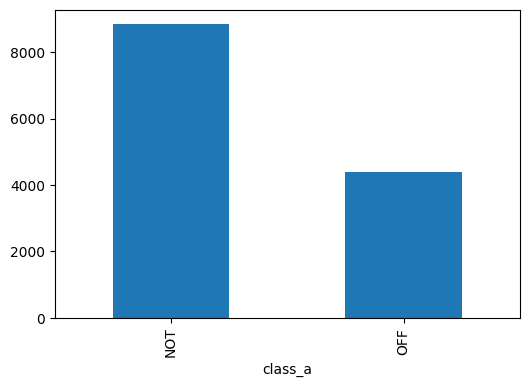

In [17]:
fig = plt.figure(figsize=(6,4))
print("train data",train_task_a_data.groupby('class_a').class_a.count())
train_task_a_data.groupby('class_a').class_a.count().plot.bar(ylim=0)
plt.show()

Augumented TaskA Data

As we can see the skew in the dataset is too large for proper classification to take place. Hence, we take the tweets with the label UNT and apply four kinds of data augumenters to them. Then, these tweets with the label UNT are added with the original dataset to give us 

In [ ]:
# Create a new DataFrame for augmented tweets
augmented_train_a = pd.DataFrame(columns=['tweet', 'class_a'])

# Iterate through the original DataFrame
for index, row in train_task_a_data.iterrows():
    tweet = row['tweet']
    label = row['class_a']

    # Only augment tweets with the label 'UNT'
    if label == 'OFF':
        random_number = random.randint(0, 3)
        if random_number==0:
            augmented_tweet = ' '.join(aug_synonym.augment(tweet.split()))
        elif random_number==1:
            augmented_tweet = ' '.join(aug_insert.augment(tweet.split()))
        elif random_number==2:
            augmented_tweet = ' '.join(aug_delete.augment(tweet.split()))
        elif random_number==3:
            augmented_tweet = ' '.join(aug_swap.augment(tweet.split()))
        augmented_train_a = augmented_train_a.append({'tweet': augmented_tweet, 'class_a': label}, ignore_index=True)

# Concatenate the original DataFrame with the augmented DataFrame
train_taska_augmented_data = pd.concat([train_task_a_data, augmented_train_a], ignore_index=True)
train_taska_augmented_data.update(train_taska_augmented_data[['tweet']].applymap('\'{}\''.format))


train data class_a
NOT    8840
OFF    8800
Name: class_a, dtype: int64


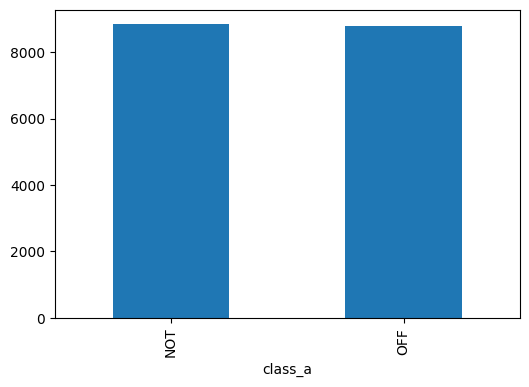

In [ ]:
fig = plt.figure(figsize=(6,4))
print("train data",train_taska_augmented_data.groupby('class_a').class_a.count())
train_taska_augmented_data.groupby('class_a').class_a.count().plot.bar(ylim=0)
plt.show()

Now the balance between both the labels is maintained. Hence, we will obtain a better classification model

##### Task B

In [24]:
train_task_b_data = train_tweets.join(train_task_b_labels)
train_task_b_data = train_task_b_data.dropna() #Drop records with missing values
train_task_b_data.update(train_task_b_data[['tweet']].applymap('\'{}\''.format))
train_task_b_data

,tweet,class_b
0,'ask native americans take',UNT
1,'go home youre drunk maga trump',TIN
3,'someone shouldvetaken piece shit volcano',UNT
5,'liberals kookoo',TIN
6,'oh noes tough shit',UNT
...,...,...
13223,'advocating conduct within bounds human rights...,TIN
13227,'liars like antifa twins vigorously defend',TIN
13235,'sometimes get strong vibes people mans vibe t...,TIN
13237,'report garbage dont give crap',TIN


train data class_b
TIN    3876
UNT     524
Name: class_b, dtype: int64


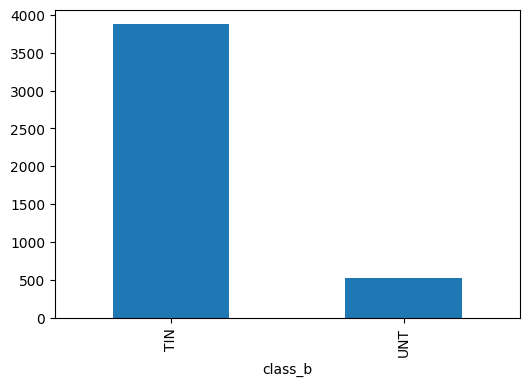

In [25]:
fig = plt.figure(figsize=(6,4))
print("train data",train_task_b_data.groupby('class_b').class_b.count())
train_task_b_data.groupby('class_b').class_b.count().plot.bar(ylim=0)
plt.show()

Augumented TaskB Data

As we can see the skew in the dataset is too large for proper classification to take place. Hence, we take the tweets with the label UNT and apply four kinds of data augumenters to them. Then, these tweets with the label UNT are added with the original dataset to give us 

In [26]:
# Create a new DataFrame for augmented tweets
augmented_train_b = pd.DataFrame(columns=['tweet', 'class_b'])

# Iterate through the original DataFrame
for index, row in train_task_b_data.iterrows():
    tweet = row['tweet']
    label = row['class_b']

    # Only augment tweets with the label 'UNT'
    if label == 'UNT':
        # Apply each augmentation technique
        augmented_synonym = ' '.join(aug_synonym.augment(tweet.split()))
        augmented_insert = ' '.join(aug_insert.augment(tweet.split()))
        augmented_delete = ' '.join(aug_delete.augment(tweet.split()))
        augmented_swap = ' '.join(aug_swap.augment(tweet.split()))

        # Add augmented tweets to the new DataFrame
        augmented_train_b = augmented_train_b.append({'tweet': augmented_synonym, 'class_b': label}, ignore_index=True)
        augmented_train_b = augmented_train_b.append({'tweet': augmented_insert, 'class_b': label}, ignore_index=True)
        augmented_train_b = augmented_train_b.append({'tweet': augmented_delete, 'class_b': label}, ignore_index=True)
        augmented_train_b = augmented_train_b.append({'tweet': augmented_swap, 'class_b': label}, ignore_index=True)

# Concatenate the original DataFrame with the augmented DataFrame
train_taskb_augmented_data = pd.concat([train_task_b_data, augmented_train_b], ignore_index=True)
train_taskb_augmented_data.update(train_taskb_augmented_data[['tweet']].applymap('\'{}\''.format))


In [27]:
train_taskb_augmented_data

,tweet,class_b
0,''ask native americans take'',UNT
1,''go home youre drunk maga trump'',TIN
2,''someone shouldvetaken piece shit volcano'',UNT
3,''liberals kookoo'',TIN
4,''oh noes tough shit'',UNT
...,...,...
6491,'Head ' fuckin ' egg',UNT
6492,'' cunt '',UNT
6493,'' the pussy '',UNT
6494,'' '',UNT


train data class_b
TIN    3876
UNT    2620
Name: class_b, dtype: int64


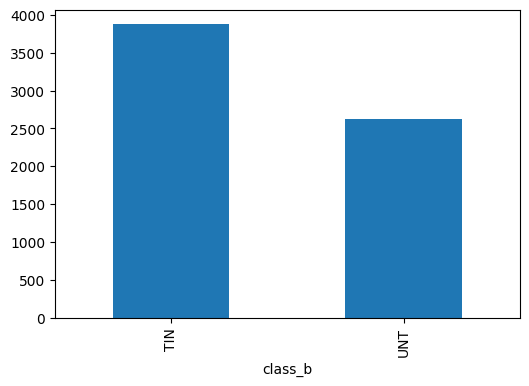

In [28]:
fig = plt.figure(figsize=(6,4))
print("train data",train_taskb_augmented_data.groupby('class_b').class_b.count())
train_taskb_augmented_data.groupby('class_b').class_b.count().plot.bar(ylim=0)
plt.show()

Now the balance between both the labels is maintained. Hence, we will obtain a better classification model

##### Task C

In [29]:
train_task_c_data = train_tweets.join(train_task_c_labels)
train_task_c_data = train_task_c_data.dropna() #Drop records with missing values
train_task_c_data.update(train_task_c_data[['tweet']].applymap('\'{}\''.format))
train_task_c_data


,tweet,class_c
1,'go home youre drunk maga trump',IND
5,'liberals kookoo',OTH
7,'literally talking lol mass shootings like set...,GRP
9,'canada doesnt need another cuck already enoug...,IND
12,'lying corrupt traitor nobody wants hear anymo...,IND
...,...,...
13212,'everything else ten years ago liar total bs p...,IND
13223,'advocating conduct within bounds human rights...,GRP
13227,'liars like antifa twins vigorously defend',GRP
13235,'sometimes get strong vibes people mans vibe t...,IND


train data class_c
GRP    1074
IND    2407
OTH     395
Name: class_c, dtype: int64


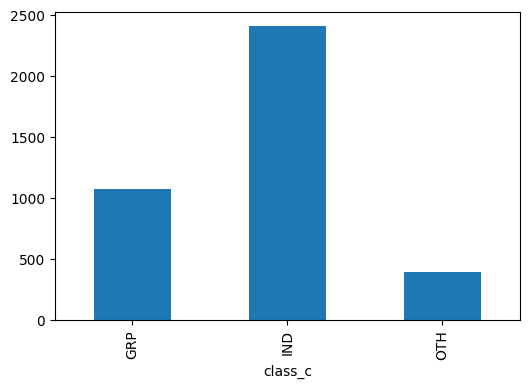

In [30]:
fig = plt.figure(figsize=(6,4))
print("train data",train_task_c_data.groupby('class_c').class_c.count())
train_task_c_data.groupby('class_c').class_c.count().plot.bar(ylim=0)
plt.show()

Here also we see a skew in the dataset. Hence, we apply data augumentation here as well.

Data Augmentation for SubtaskC

In the following code, we apply data augumentation on both the GRP labels and the OTH labels to balance the data

In [74]:
# Create a new DataFrame for augmented tweets
augmented_train_c = pd.DataFrame(columns=['tweet', 'class_c'])

# Iterate through the original DataFrame
for index, row in train_task_c_data.iterrows():
    tweet = row['tweet']
    label = row['class_c']
    # Only augment tweets with the label 'UNT'
    if label == 'GRP':
        # Apply each augmentation technique
        augmented_synonym = ' '.join(aug_synonym.augment(tweet.split()))
        augmented_insert = ' '.join(aug_insert.augment(tweet.split()))
        augmented_delete = ' '.join(aug_delete.augment(tweet.split()))
        augmented_swap = ' '.join(aug_swap.augment(tweet.split()))
        aug=[augmented_synonym, augmented_insert, augmented_delete, augmented_swap]
        # Add augmented tweets to the new DataFrame
        random_number = random.randint(0, 3)
        augmented_train_c = augmented_train_c.append({'tweet': aug[random_number], 'class_c': label}, ignore_index=True)
        # Print the number of tweets added to the DataFrame
    elif label== 'OTH':
        # Apply each augmentation technique
        augmented_synonym = ' '.join(aug_synonym.augment(tweet.split()))
        augmented_insert = ' '.join(aug_insert.augment(tweet.split()))
        augmented_delete = ' '.join(aug_delete.augment(tweet.split()))
        augmented_swap = ' '.join(aug_swap.augment(tweet.split()))

        augmented_train_c = augmented_train_c.append({'tweet': augmented_synonym, 'class_c': label}, ignore_index=True)
        augmented_train_c = augmented_train_c.append({'tweet': augmented_insert, 'class_c': label}, ignore_index=True)
        augmented_train_c = augmented_train_c.append({'tweet': augmented_delete, 'class_c': label}, ignore_index=True)
        augmented_train_c = augmented_train_c.append({'tweet': augmented_swap, 'class_c': label}, ignore_index=True)

In [75]:
# Concatenate the original DataFrame with the augmented DataFrame
train_taskc_augmented_data = pd.concat([train_task_c_data, augmented_train_c], ignore_index=True)
train_taskc_augmented_data.update(train_taskc_augmented_data[['tweet']].applymap('\'{}\''.format))

In [76]:
# Display the augmented dataset
print(train_taskc_augmented_data)

                                                  tweet class_c  class_c_code  \
0                    ''go home youre drunk maga trump''     IND           1.0   
1                                   ''liberals kookoo''     OTH           2.0   
2     ''literally talking lol mass shootings like se...     GRP           0.0   
3     ''canada doesnt need another cuck already enou...     IND           1.0   
4     ''lying corrupt traitor nobody wants hear anym...     IND           1.0   
...                                                 ...     ...           ...   
6525  '' liar corresponding antifa similitude smartl...     GRP           NaN   
6526              '' study scraps dont collapse bull ''     OTH           NaN   
6527  '' general report free garbage just dont so gi...     OTH           NaN   
6528                            '' garbage dont give ''     OTH           NaN   
6529                'Report ' garbage dont give ' crap'     OTH           NaN   

     class-tuple  
0       

train data class_c
GRP    2148
IND    2407
OTH    1975
Name: class_c, dtype: int64


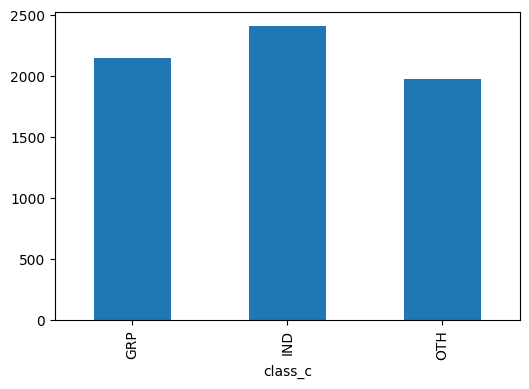

In [ ]:
fig = plt.figure(figsize=(6,4))
print("train data",train_taskc_augmented_data.groupby('class_c').class_c.count())
train_taskc_augmented_data.groupby('class_c').class_c.count().plot.bar(ylim=0)
plt.show()

Hence the dataset has been stablilized

#### Preparing the test sets

##### Task A

In [36]:
#Read tweets from test sets
test_tweet_a=pd.read_csv('./Datasets/testset-levela.tsv', delimiter='\t', encoding='utf-8')
test_label_a=pd.read_csv('./Datasets/labels-levela.csv', encoding='utf-8', index_col=False, names=['id', 'class_a'])
test_tweet_a = test_tweet_a.merge(test_label_a, on='id')
test_tweet_a = test_tweet_a.drop(columns='id')
clean_tweets(test_tweet_a)
test_tweet_a.update(test_tweet_a[['tweet']].applymap('\'{}\''.format))
test_tweet_a

,tweet,class_a
0,'whoisq wherestheserver dumpnike declasfisa de...,OFF
1,'constitutionday revered conservatives hated p...,NOT
2,'foxnews nra maga potus trump ndamendment rnc ...,NOT
3,'watching boomer getting news still parole alw...,NOT
4,'nopasaran unity demo oppose farright london a...,OFF
...,...,...
855,'despicabledems lie rifles dem distorted law p...,OFF
856,'meetthespeakers present event oiw finpact glo...,NOT
857,'people unfollowed talking merlin sorry yall i...,OFF
858,'wednesdaywisdom antifa calls right fascist re...,NOT


test data class_a
NOT    620
OFF    240
Name: class_a, dtype: int64


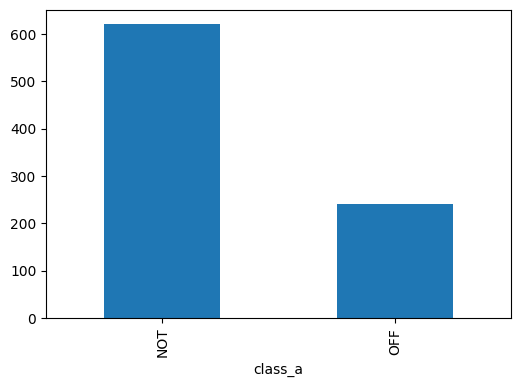

In [37]:
fig = plt.figure(figsize=(6,4))
print("test data",test_tweet_a.groupby('class_a').class_a.count())
test_tweet_a.groupby('class_a').class_a.count().plot.bar(ylim=0)
plt.show()

Augumenting the Test Dataset (Not necessary only for evaluation purposes)

In [ ]:
# Create a new DataFrame for augmented tweets
augmented_test_a = pd.DataFrame(columns=['tweet', 'class_a'])

# Iterate through the original DataFrame
for index, row in test_tweet_a.iterrows():
    tweet = row['tweet']
    label = row['class_a']

    # Only augment tweets with the label 'UNT'
    if label == 'OFF':
        random_number = random.randint(0, 3)
        if random_number==0:
            augmented_tweet = ' '.join(aug_synonym.augment(tweet.split()))
        elif random_number==1:
            augmented_tweet = ' '.join(aug_insert.augment(tweet.split()))
        elif random_number==2:
            augmented_tweet = ' '.join(aug_delete.augment(tweet.split()))
        elif random_number==3:
            augmented_tweet = ' '.join(aug_swap.augment(tweet.split()))
        augmented_test_a = augmented_test_a.append({'tweet': augmented_tweet, 'class_a': label}, ignore_index=True)


In [ ]:
# Concatenate the original DataFrame with the augmented DataFrame
test_taska_augmented_data = pd.concat([test_tweet_a, augmented_test_a], ignore_index=True)
test_taska_augmented_data.update(test_taska_augmented_data[['tweet']].applymap('\'{}\''.format))

# Display the augmented dataset
test_taska_augmented_data

,tweet,class_a,class_a_code
0,''whoisq wherestheserver dumpnike declasfisa d...,OFF,1.0
1,''constitutionday revered conservatives hated ...,NOT,0.0
2,''foxnews nra maga potus trump ndamendment rnc...,NOT,0.0
3,''watching boomer getting news still parole al...,NOT,0.0
4,''nopasaran unity demo oppose farright london ...,OFF,1.0
...,...,...,...
1095,'' mentally unstable cowards pretending '',OFF,NaN
1096,'Browning ' looked like dog shit fcs school wh...,OFF,NaN
1097,'' book two a taste sounds like that ass '',OFF,NaN
1098,'' a despicabledems ... lie imperial rifles co...,OFF,NaN


test data class_a
NOT    620
OFF    480
Name: class_a, dtype: int64


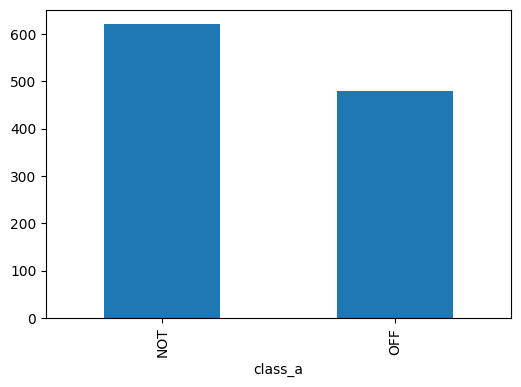

In [ ]:
fig = plt.figure(figsize=(6,4))
print("test data",test_taska_augmented_data.groupby('class_a').class_a.count())
test_taska_augmented_data.groupby('class_a').class_a.count().plot.bar(ylim=0)
plt.show()

##### Task B

In [38]:
test_tweet_b=pd.read_csv('./Datasets/testset-levelb.tsv', delimiter='\t', encoding='utf-8')
test_label_b=pd.read_csv('./Datasets/labels-levelb.csv', encoding='utf-8', index_col=False, names=['id', 'class_b'])
test_tweet_b = test_tweet_b.merge(test_label_b, on='id')
test_tweet_b = test_tweet_b.drop(columns='id')
clean_tweets(test_tweet_b)
test_tweet_b.update(test_tweet_b[['tweet']].applymap('\'{}\''.format))
test_tweet_b

,tweet,class_b
0,'whoisq wherestheserver dumpnike declasfisa de...,TIN
1,'nopasaran unity demo oppose farright london a...,TIN
2,'fuck time',TIN
3,'get feeling kissing behind humiliate later',TIN
4,'nigga ware da hits',UNT
...,...,...
235,'antifa mentally unstable cowards pretending r...,TIN
236,'browning looked like dog shit fcs school what...,TIN
237,'two taste like ass',TIN
238,'despicabledems lie rifles dem distorted law p...,TIN


test data class_b
TIN    213
UNT     27
Name: class_b, dtype: int64


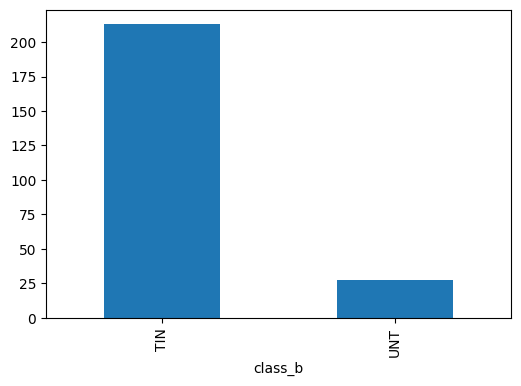

In [39]:
fig = plt.figure(figsize=(6,4))
print("test data",test_tweet_b.groupby('class_b').class_b.count())
test_tweet_b.groupby('class_b').class_b.count().plot.bar(ylim=0)
plt.show()

Augumenting the Test Dataset (Not necessary only for evaluation purposes)

In [60]:
# Create a new DataFrame for augmented tweets
augmented_test_b = pd.DataFrame(columns=['tweet', 'class_b'])

# Iterate through the original DataFrame
for index, row in test_tweet_b.iterrows():
    tweet = row['tweet']
    label = row['class_b']

    # Only augment tweets with the label 'UNT'
    if label == 'UNT':
        # Apply each augmentation technique
        augmented_synonym = ' '.join(aug_synonym.augment(tweet.split()))
        augmented_insert = ' '.join(aug_insert.augment(tweet.split()))
        augmented_delete = ' '.join(aug_delete.augment(tweet.split()))
        augmented_swap = ' '.join(aug_swap.augment(tweet.split()))

        # Add augmented tweets to the new DataFrame
        augmented_test_b = augmented_test_b.append({'tweet': augmented_synonym, 'class_b': label}, ignore_index=True)
        augmented_test_b = augmented_test_b.append({'tweet': augmented_insert, 'class_b': label}, ignore_index=True)
        augmented_test_b = augmented_test_b.append({'tweet': augmented_delete, 'class_b': label}, ignore_index=True)
        augmented_test_b = augmented_test_b.append({'tweet': augmented_swap, 'class_b': label}, ignore_index=True)

In [61]:
# Concatenate the original DataFrame with the augmented DataFrame
test_taskb_augmented_data = pd.concat([test_tweet_b, augmented_test_b], ignore_index=True)
test_taskb_augmented_data.update(test_taskb_augmented_data[['tweet']].applymap('\'{}\''.format))

# Display the augmented dataset
test_taskb_augmented_data

,tweet,class_b,class_b_code
0,''whoisq wherestheserver dumpnike declasfisa d...,TIN,0.0
1,''nopasaran unity demo oppose farright london ...,TIN,0.0
2,''fuck time'',TIN,0.0
3,''get feeling kissing behind humiliate later'',TIN,0.0
4,''nigga ware da hits'',UNT,1.0
...,...,...,...
343,'Howtogetpeopleoutofyourhome ' tell youre vamp...,UNT,NaN
344,'' hoi polloi unfollowed talk falco columbariu...,UNT,NaN
345,'' young people it unfollowed for talking casa...,UNT,NaN
346,'' unfollowed talking merlin sorry yall im sti...,UNT,NaN


In [62]:
tweet1=test_taskb_augmented_data['tweet'][347]

test data class_b
TIN    213
UNT    135
Name: class_b, dtype: int64


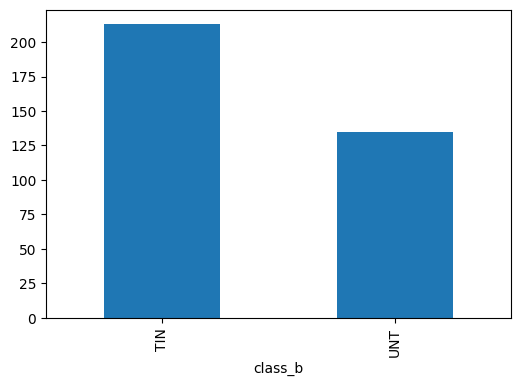

In [63]:
fig = plt.figure(figsize=(6,4))
print("test data",test_taskb_augmented_data.groupby('class_b').class_b.count())
test_taskb_augmented_data.groupby('class_b').class_b.count().plot.bar(ylim=0)
plt.show()

##### Task C

In [40]:
test_tweet_c=pd.read_csv('./Datasets/testset-levelc.tsv', delimiter='\t', encoding='utf-8')
test_label_c=pd.read_csv('./Datasets/labels-levelc.csv', encoding='utf-8', index_col=False, names=['id', 'class_c'])
test_tweet_c = test_tweet_c.merge(test_label_c, on='id')
test_tweet_c = test_tweet_c.drop(columns='id')
clean_tweets(test_tweet_c)
test_tweet_c.update(test_tweet_c[['tweet']].applymap('\'{}\''.format))
test_tweet_c

,tweet,class_c
0,'whoisq wherestheserver dumpnike declasfisa de...,OTH
1,'nopasaran unity demo oppose farright london a...,GRP
2,'fuck time',IND
3,'get feeling kissing behind humiliate later',OTH
4,'stopkavanaugh liar like rest gop',IND
...,...,...
208,'stopetchecopar fuck que florezcan mil baby et...,IND
209,'antifa mentally unstable cowards pretending r...,GRP
210,'browning looked like dog shit fcs school what...,IND
211,'two taste like ass',GRP


test data class_c
GRP     78
IND    100
OTH     35
Name: class_c, dtype: int64


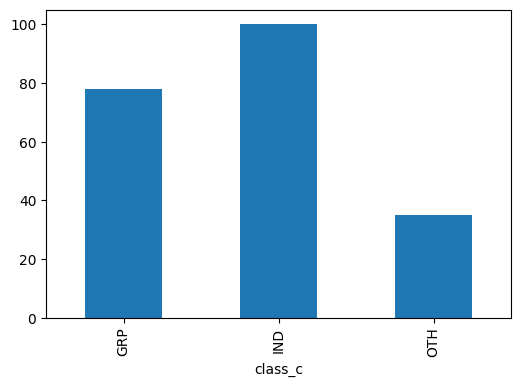

In [41]:
# Quick look at the topic numbers on the total dataset
fig = plt.figure(figsize=(6,4))
print("test data",test_tweet_c.groupby('class_c').class_c.count())
test_tweet_c.groupby('class_c').class_c.count().plot.bar(ylim=0)
plt.show()

Augmentation for Testset TaskC (Optional)

In [64]:
# Create a new DataFrame for augmented tweets
augmented_test_c = pd.DataFrame(columns=['tweet', 'class_c'])

# Iterate through the original DataFrame
for index, row in test_tweet_c.iterrows():
    tweet = row['tweet']
    label = row['class_c']
    # Only augment tweets with the label 'UNT'
    if label == 'OTH':
        # Apply each augmentation technique
        augmented_synonym = ' '.join(aug_synonym.augment(tweet.split()))
        augmented_insert = ' '.join(aug_insert.augment(tweet.split()))
        augmented_delete = ' '.join(aug_delete.augment(tweet.split()))
        augmented_swap = ' '.join(aug_swap.augment(tweet.split()))
        aug=[augmented_synonym, augmented_insert, augmented_delete, augmented_swap]
        # Add augmented tweets to the new DataFrame
        random_number = random.randint(0, 3)
        augmented_test_c = augmented_test_c.append({'tweet': aug[random_number], 'class_c': label}, ignore_index=True)

In [71]:
test_taskc_augmented_data = pd.concat([test_tweet_c, augmented_test_c], ignore_index=True)
test_taskc_augmented_data.update(test_taskc_augmented_data[['tweet']].applymap('\'{}\''.format))

test_taskc_augmented_data

,tweet,class_c,class_c_code
0,''whoisq wherestheserver dumpnike declasfisa d...,OTH,2.0
1,''nopasaran unity demo oppose farright london ...,GRP,0.0
2,''fuck time'',IND,1.0
3,''get feeling kissing behind humiliate later'',OTH,2.0
4,''stopkavanaugh liar like rest gop'',IND,1.0
...,...,...,...
243,'' mary christineblaseyford [UNK] grinding pau...,OTH,NaN
244,'' at justiceforsoniasfather contents mr natha...,OTH,NaN
245,'Sick ' ass ppl school gave something chug nas...,OTH,NaN
246,'' dumberthandogshit central point '',OTH,NaN


test data class_c
GRP     78
IND    100
OTH     70
Name: class_c, dtype: int64


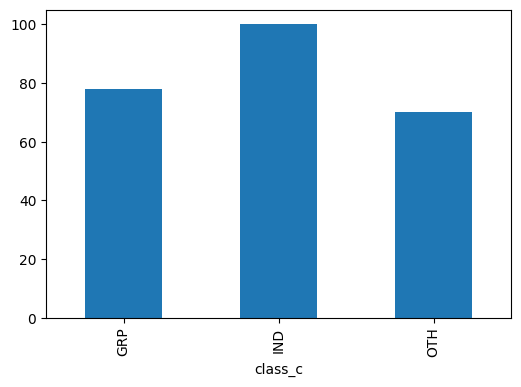

In [72]:
fig = plt.figure(figsize=(6,4))
print("test data",test_taskc_augmented_data.groupby('class_c').class_c.count())
test_taskc_augmented_data.groupby('class_c').class_c.count().plot.bar(ylim=0)
plt.show()

## Models

### 1st Model - MultinomialNB Naive Bayes

#### Functions

In [30]:
def MultinomialNBModel_Preprocess(dataset_train,dataset_test,ch):
    taskclass="class_"+ch
    taskclasscode=taskclass+"_code"
    encoder=LabelEncoder()
    dataset_train[taskclasscode]=encoder.fit_transform(dataset_train[taskclass])
    dataset_test[taskclasscode]=encoder.fit_transform(dataset_test[taskclass])
    dataset_train['class-tuple']=dataset_train[[taskclass, taskclasscode]].apply(tuple,axis=1)
    class_task=dataset_train['class-tuple'].unique()
    X_train=dataset_train['tweet']
    y_train=dataset_train[taskclasscode]
    X_test=dataset_test['tweet']
    y_test=dataset_test[taskclasscode]
    return class_task, X_train,y_train, X_test, y_test


In [67]:
from Utils import predictor, retrainer
df_socio.update(df_socio[['tweet']].applymap('\'{}\''.format))


encoder=LabelEncoder()

In [68]:
df_socio['class_a_code']=encoder.fit_transform(df_socio['subtask_a'])
df_socio

,tweet,subtask_a,class_a_code
0,'ask native americans take',OFF,1
1,'go home youre drunk maga trump',OFF,1
2,'amazon investigating chinese employees sellin...,NOT,0
3,'someone shouldvetaken piece shit volcano',OFF,1
4,'obama wanted liberals illegals move red states',NOT,0
...,...,...,...
495,'stoned wheat crackers hell put stoned wheat c...,OFF,1
496,'remember ok ok tcot ccot maga kag qanon walka...,NOT,0
497,'fordnation onpoli conservatives conservative ...,OFF,1
498,'common sense gun control would indicate loone...,NOT,0


In [33]:
def MultinomialNB_Model(X_train,y_train,X_test,y_test):
    model=MultinomialNB()
    pipeline_Mnv = Pipeline([('vectorizer', TfidfVectorizer(sublinear_tf=True, min_df=5,norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')),('classifier', model)])
    pipeline_Mnv.fit(X_train, y_train)
    y_pred = pipeline_Mnv.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    class_report=metrics.classification_report(y_test,y_pred)
    return pipeline_Mnv,accuracy, class_report,y_pred

In [69]:
df_socio['class_a']=df_socio['subtask_a']
df_socio

,tweet,subtask_a,class_a_code,class_a
0,'ask native americans take',OFF,1,OFF
1,'go home youre drunk maga trump',OFF,1,OFF
2,'amazon investigating chinese employees sellin...,NOT,0,NOT
3,'someone shouldvetaken piece shit volcano',OFF,1,OFF
4,'obama wanted liberals illegals move red states',NOT,0,NOT
...,...,...,...,...
495,'stoned wheat crackers hell put stoned wheat c...,OFF,1,OFF
496,'remember ok ok tcot ccot maga kag qanon walka...,NOT,0,NOT
497,'fordnation onpoli conservatives conservative ...,OFF,1,OFF
498,'common sense gun control would indicate loone...,NOT,0,NOT


#### Task A

In [70]:
class_a, X_train, y_train, X_test, y_test= MultinomialNBModel_Preprocess(train_task_a_data, df_socio,"a")
print(class_a)
print("Shape of X_train is {} and shape of y_train is {}".format(X_train.shape, y_train.shape))
print("Shape of X_test is {} and shape of y_test is {}".format(X_test.shape, y_test.shape))

[('OFF', 1) ('NOT', 0)]
Shape of X_train is (13240,) and shape of y_train is (13240,)
Shape of X_test is (500,) and shape of y_test is (500,)


In [47]:
# MultinomialNB Model
model_a_nb,acc_a_nb,class_report_a_nb,y_pred_a_nb= MultinomialNB_Model(X_train,y_train,X_test,y_test)

print("model accuracy:",acc_a_nb)
print("\n",class_report_a_nb)

model accuracy: 0.7976744186046512

               precision    recall  f1-score   support

           0       0.79      0.97      0.87       620
           1       0.82      0.35      0.49       240

    accuracy                           0.80       860
   macro avg       0.81      0.66      0.68       860
weighted avg       0.80      0.80      0.77       860



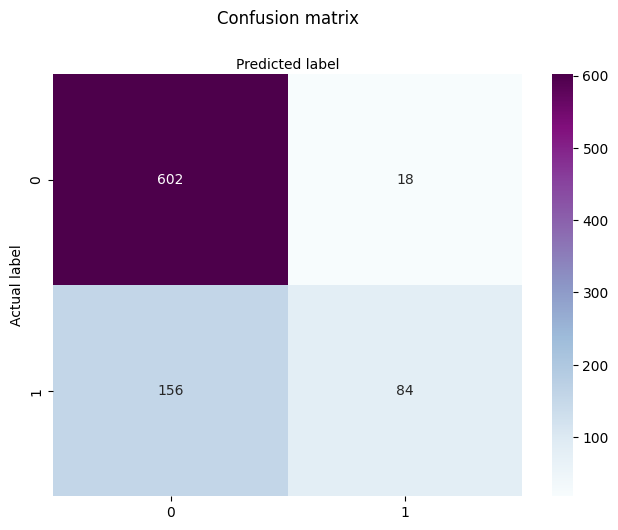

In [48]:
plot_conf_matrix(y_test,y_pred_a_nb)

Let us try the same with augumented data

In [ ]:
class_a_aug, X_train, y_train, X_test, y_test= MultinomialNBModel_Preprocess(train_taska_augmented_data, test_taska_augmented_data,"a")
print(class_a_aug)
print("Shape of X_train is {} and shape of y_train is {}".format(X_train.shape, y_train.shape))
print("Shape of X_test is {} and shape of y_test is {}".format(X_test.shape, y_test.shape))

[('OFF', 1) ('NOT', 0)]
Shape of X_train is (17640,) and shape of y_train is (17640,)
Shape of X_test is (1100,) and shape of y_test is (1100,)


In [ ]:
model_a_aug_nb,acc_a_aug_nb,class_report_a_aug_nb,y_pred_a_aug_nb= MultinomialNB_Model(X_train,y_train,X_test,y_test)

print("model accuracy:",acc_a_aug_nb)
print("\n",class_report_a_aug_nb)

model accuracy: 0.7363636363636363

               precision    recall  f1-score   support

           0       0.74      0.83      0.78       620
           1       0.74      0.61      0.67       480

    accuracy                           0.74      1100
   macro avg       0.74      0.72      0.73      1100
weighted avg       0.74      0.74      0.73      1100



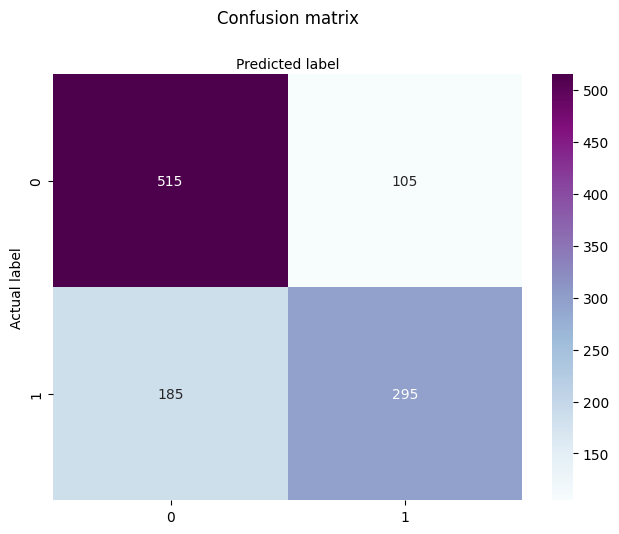

In [ ]:
plot_conf_matrix(y_test,y_pred_a_aug_nb)

Hence, we can see that our model classifies slightly better with the augumented data

#### Task B

In [57]:
class_b, X_train, y_train, X_test, y_test= MultinomialNBModel_Preprocess(train_task_b_data, test_tweet_b,"b")
print(class_b)
print("Shape of X_train is {} and shape of y_train is {}".format(X_train.shape, y_train.shape))
print("Shape of X_test is {} and shape of y_test is {}".format(X_test.shape, y_test.shape))

[('UNT', 1) ('TIN', 0)]
Shape of X_train is (4400,) and shape of y_train is (4400,)
Shape of X_test is (240,) and shape of y_test is (240,)


In [58]:
model_b_nb,acc_b_nb,class_report_b_nb,y_pred_b_nb= MultinomialNB_Model(X_train,y_train,X_test,y_test)

print("model accuracy:",acc_b_nb)
print("\n",class_report_b_nb)

model accuracy: 0.8875

               precision    recall  f1-score   support

           0       0.89      1.00      0.94       213
           1       0.00      0.00      0.00        27

    accuracy                           0.89       240
   macro avg       0.44      0.50      0.47       240
weighted avg       0.79      0.89      0.83       240



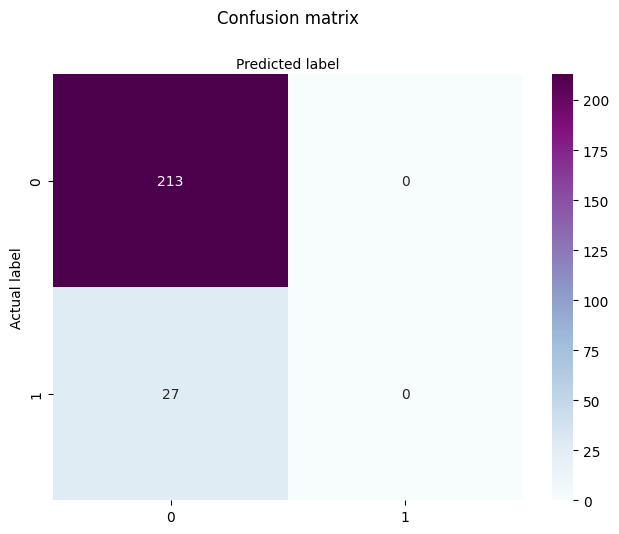

In [ ]:
plot_conf_matrix(y_test,y_pred_b_nb)

Let us try the same with augumented data

In [68]:
class_b_aug, X_train, y_train, X_test, y_test= MultinomialNBModel_Preprocess(train_taskb_augmented_data, test_taskb_augmented_data,"b")
print(class_b_aug)
print("Shape of X_train is {} and shape of y_train is {}".format(X_train.shape, y_train.shape))
print("Shape of X_test is {} and shape of y_test is {}".format(X_test.shape, y_test.shape))

[('UNT', 1) ('TIN', 0)]
Shape of X_train is (6496,) and shape of y_train is (6496,)
Shape of X_test is (348,) and shape of y_test is (348,)


In [69]:
model_b_aug_nb,acc_b_aug_nb,class_report_b_aug_nb,y_pred_b_aug_nb= MultinomialNB_Model(X_train,y_train,X_test,y_test)

print("model accuracy:",acc_b_aug_nb)
print("\n",class_report_b_aug_nb)

model accuracy: 0.7270114942528736

               precision    recall  f1-score   support

           0       0.71      0.93      0.81       213
           1       0.79      0.40      0.53       135

    accuracy                           0.73       348
   macro avg       0.75      0.67      0.67       348
weighted avg       0.74      0.73      0.70       348



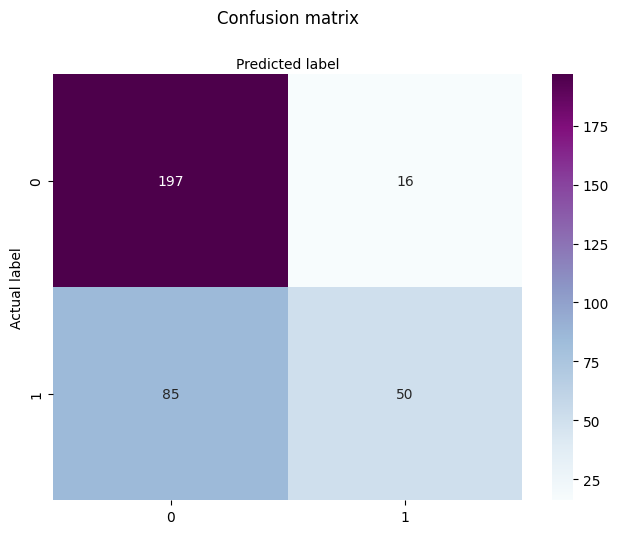

In [ ]:
plot_conf_matrix(y_test,y_pred_b_aug_nb)

Hence, we can see that our model classifies slightly better with the augumented data

#### Task C

In [51]:
class_c, X_train, y_train, X_test, y_test= MultinomialNBModel_Preprocess(train_task_c_data, test_tweet_c,"c")
print(class_c)
print("Shape of X_train is {} and shape of y_train is {}".format(X_train.shape, y_train.shape))
print("Shape of X_test is {} and shape of y_test is {}".format(X_test.shape, y_test.shape))

[('IND', 1) ('OTH', 2) ('GRP', 0)]
Shape of X_train is (3876,) and shape of y_train is (3876,)
Shape of X_test is (213,) and shape of y_test is (213,)


In [52]:
model_c_nb,acc_c_nb,class_report_c_nb,y_pred_c_nb= MultinomialNB_Model(X_train,y_train,X_test,y_test)

print("model accuracy:",acc_c_nb)
print("\n",class_report_c_nb)

model accuracy: 0.5633802816901409

               precision    recall  f1-score   support

           0       0.69      0.35      0.46        78
           1       0.53      0.93      0.68       100
           2       0.00      0.00      0.00        35

    accuracy                           0.56       213
   macro avg       0.41      0.43      0.38       213
weighted avg       0.50      0.56      0.49       213



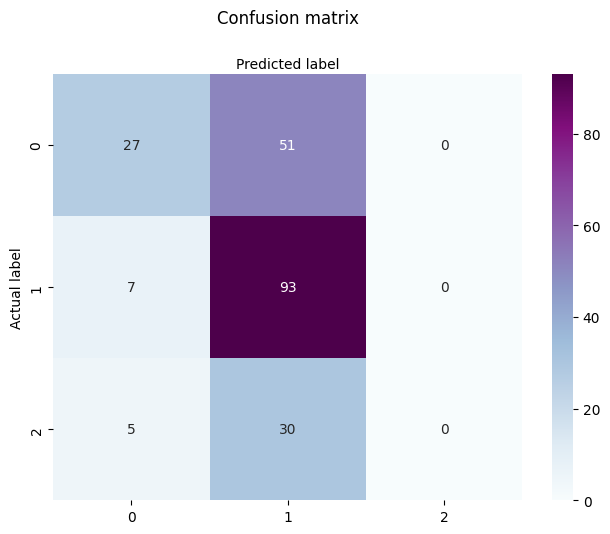

In [ ]:
plot_conf_matrix(y_test,y_pred_c_nb)

Let us try the same with augumented data

In [77]:
class_c_aug, X_train, y_train, X_test, y_test= MultinomialNBModel_Preprocess(train_taskc_augmented_data, test_taskc_augmented_data,"c")
print(class_c_aug)
print("Shape of X_train is {} and shape of y_train is {}".format(X_train.shape, y_train.shape))
print("Shape of X_test is {} and shape of y_test is {}".format(X_test.shape, y_test.shape))

[('IND', 1) ('OTH', 2) ('GRP', 0)]
Shape of X_train is (6530,) and shape of y_train is (6530,)
Shape of X_test is (248,) and shape of y_test is (248,)


In [78]:
model_c_aug_nb,acc_c_aug_nb,class_report_c_aug_nb,y_pred_c_aug_nb= MultinomialNB_Model(X_train,y_train,X_test,y_test)

print("model accuracy:",acc_c_aug_nb)
print("\n",class_report_c_aug_nb)

model accuracy: 0.5604838709677419

               precision    recall  f1-score   support

           0       0.52      0.62      0.56        78
           1       0.59      0.81      0.68       100
           2       0.56      0.14      0.23        70

    accuracy                           0.56       248
   macro avg       0.55      0.52      0.49       248
weighted avg       0.56      0.56      0.52       248



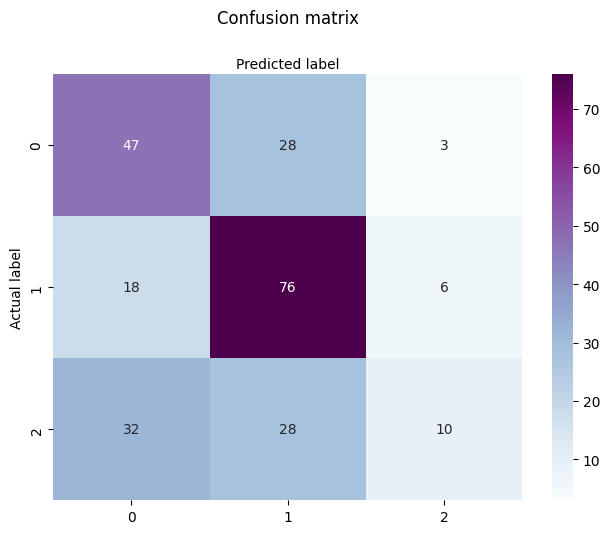

In [ ]:
plot_conf_matrix(y_test,y_pred_c_aug_nb)

### 2nd Model - LSTM Text Classification

#### Functions

In [25]:
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence
from keras.optimizers import RMSprop
from keras.models import Model


In [26]:
def LSTM_preprocess(dataset_train,dataset_test,ch):
    taskclass="class_"+ch+"_code"
    encoder=LabelEncoder()
    X_train=dataset_train['tweet']
    y_train=dataset_train[taskclass]
    X_test=dataset_test['tweet']
    y_test=dataset_test[taskclass]
    le=LabelEncoder()
    Y_train=le.fit_transform(y_train)
    Y_train=Y_train.reshape(-1,1)
    Y_test=le.fit_transform(y_test)
    Y_test=Y_test.reshape(-1,1)
    return X_train, Y_train, X_test, Y_test

In [71]:
df_socio


,tweet,subtask_a,class_a_code,class_a
0,'ask native americans take',OFF,1,OFF
1,'go home youre drunk maga trump',OFF,1,OFF
2,'amazon investigating chinese employees sellin...,NOT,0,NOT
3,'someone shouldvetaken piece shit volcano',OFF,1,OFF
4,'obama wanted liberals illegals move red states',NOT,0,NOT
...,...,...,...,...
495,'stoned wheat crackers hell put stoned wheat c...,OFF,1,OFF
496,'remember ok ok tcot ccot maga kag qanon walka...,NOT,0,NOT
497,'fordnation onpoli conservatives conservative ...,OFF,1,OFF
498,'common sense gun control would indicate loone...,NOT,0,NOT


In [27]:
def RNN(max_words,max_len):
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [50]:
def LSTM_Model(X_train,y_train, X_test,y_test):
    max_words = 1000
    max_len = 150
    tok = Tokenizer(num_words=max_words)
    tok.fit_on_texts(X_train)
    sequences = tok.texts_to_sequences(X_train)
    sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
    model=RNN(max_words,max_len)
    print(model.summary())
    model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])
    model.fit(sequences_matrix,y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])
    test_sequences = tok.texts_to_sequences(X_test)
    test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
    accr = model.evaluate(test_sequences_matrix,y_test)
    y_pred=model.predict(test_sequences_matrix)
    return model, y_pred,accr

#### Task A

In [72]:
X_train, y_train, X_test, y_test= LSTM_preprocess(train_task_a_data,df_socio, "a")
print("Shape of X_train is {} and shape of y_train is {}".format(X_train.shape, y_train.shape))
print("Shape of X_test is {} and shape of y_test is {}".format(X_test.shape, y_test.shape))

Shape of X_train is (13240,) and shape of y_train is (13240, 1)
Shape of X_test is (500,) and shape of y_test is (500, 1)


In [73]:
model_a_lstm, y_pred_a_lstm, acc_a_lstm=LSTM_Model(X_train,y_train, X_test, y_test)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 150, 50)           50000     
                                                                 
 lstm_2 (LSTM)               (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_4 (Activation)   (None, 256)               0         
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

In [51]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc_a_lstm[0],acc_a_lstm[1]))

Test set
  Loss: 0.570
  Accuracy: 0.760


In [52]:
plot_conf_matrix(y_test,y_pred_a_lstm)

ValueError: Classification metrics can't handle a mix of binary and continuous targets

On the Augumented Data

In [ ]:
X_train, y_train, X_test, y_test= LSTM_preprocess(train_taska_augmented_data,test_taska_augmented_data, "a")
print("Shape of X_train is {} and shape of y_train is {}".format(X_train.shape, y_train.shape))
print("Shape of X_test is {} and shape of y_test is {}".format(X_test.shape, y_test.shape))

Shape of X_train is (17640,) and shape of y_train is (17640, 1)
Shape of X_test is (1100,) and shape of y_test is (1100, 1)


In [ ]:
model_a_aug_lstm, y_pred_a_aug_lstm, acc_a_aug_lstm=LSTM_Model(X_train,y_train, X_test, y_test)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_10 (Embedding)    (None, 150, 50)           50000     
                                                                 
 lstm_10 (LSTM)              (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_20 (Activation)  (None, 256)               0         
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257

In [ ]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc_a_aug_lstm[0],acc_a_aug_lstm[1]))

Test set
  Loss: 0.400
  Accuracy: 0.822


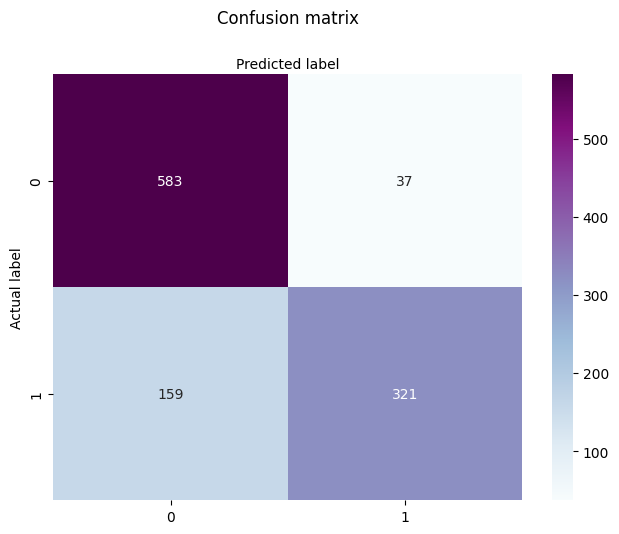

In [ ]:
plot_conf_matrix(y_test,y_pred_a_aug_lstm)

#### Task B

For task B, we straight away perform the model on th augmented data

In [79]:
X_train, y_train, X_test, y_test= LSTM_preprocess(train_taskb_augmented_data,test_taskb_augmented_data, "b")
print("Shape of X_train is {} and shape of y_train is {}".format(X_train.shape, y_train.shape))
print("Shape of X_test is {} and shape of y_test is {}".format(X_test.shape, y_test.shape))

Shape of X_train is (6496,) and shape of y_train is (6496, 1)
Shape of X_test is (348,) and shape of y_test is (348, 1)


In [80]:
model_b_lstm, y_pred_b_lstm, acc_b_lstm=LSTM_Model(X_train,y_train, X_test, y_test)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 150, 50)           50000     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_2 (Activation)   (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

In [ ]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc_b_lstm[0],acc_b_lstm[1]))

Test set
  Loss: 0.248
  Accuracy: 0.908


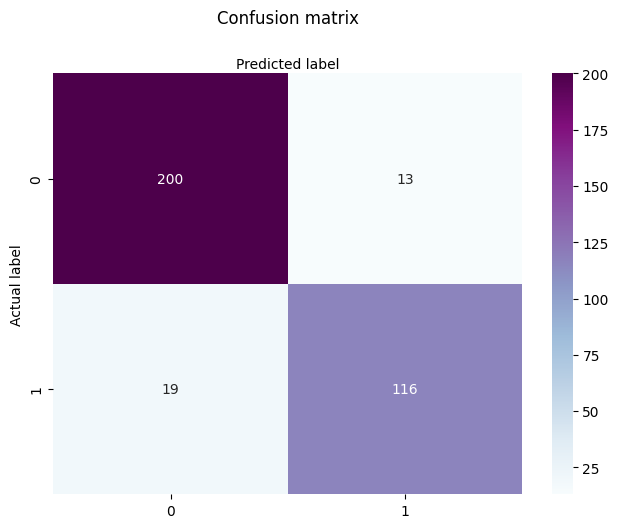

In [ ]:
plot_conf_matrix(y_test,y_pred_b_lstm)

#### Task C

In [82]:
X_train, y_train, X_test, y_test= LSTM_preprocess(train_taskc_augmented_data,test_taskc_augmented_data, "c")
print("Shape of X_train is {} and shape of y_train is {}".format(X_train.shape, y_train.shape))
print("Shape of X_test is {} and shape of y_test is {}".format(X_test.shape, y_test.shape))

Shape of X_train is (6530,) and shape of y_train is (6530, 1)
Shape of X_test is (248,) and shape of y_test is (248, 1)


In [83]:
model_c_lstm, y_pred_c_lstm, acc_c_lstm=LSTM_Model(X_train,y_train, X_test, y_test)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 150, 50)           50000     
                                                                 
 lstm_2 (LSTM)               (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation_4 (Activation)   (None, 256)               0         
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257 

In [84]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(acc_c_lstm[0],acc_c_lstm[1]))

Test set
  Loss: -45.730
  Accuracy: 0.423


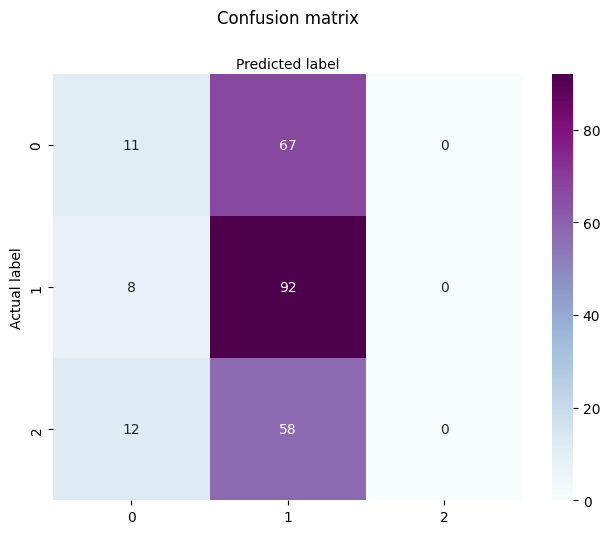

In [ ]:
plot_conf_matrix(y_test,y_pred_c_lstm)

## Conclusion

In [ ]:
# Your variable values (replace these with your actual values)

# Creating a DataFrame
data = {
    'LSTM ': [ acc_a_lstm[1],acc_a_aug_lstm[1] , "NA", acc_b_lstm[1], "NA", acc_c_lstm[1]],
    'Multinomial NB': [acc_a_nb, acc_a_aug_nb, acc_b_nb, acc_b_aug_nb, acc_c_nb, acc_c_aug_nb]
}

df = pd.DataFrame(data, index=['Task A','TaskA_Aug' ,'Task B', 'TaskB_Aug', 'Task C', 'TaskC_Aug'])

# Display the DataFrame
df


,LSTM,Multinomial NB
Task A,0.754651,0.797674
TaskA_Aug,0.821818,0.736364
Task B,NA,0.887500
TaskB_Aug,0.908046,0.709770
Task C,NA,0.563380
TaskC_Aug,0.415323,0.536290


As we can see from the above table, the highest accuracies for each subtask with correct classifications are:

- Subtask A: LSTM Model trained on Augmented Data
- Subtask B: LSTM Model trained on Augmented Data
- Subtask C: Multinomial NB Model trained on Augmented Data

Now we shall pickle these models for later use

In [ ]:
with open('model_a.pkl', 'wb') as file:
    pickle.dump(model_a_nb, file)
with open('model_b.pkl', 'wb') as file:
    pickle.dump(model_b_aug_nb, file)
with open('model_c.pkl', 'wb') as file:
    pickle.dump(model_c_aug_nb, file)

In [75]:
df = pd.DataFrame(df_socio)


# Predict probabilities for the tweets
df['PredictedProb'] = y_pred_a_lstm
df

,tweet,subtask_a,class_a_code,class_a,PredictedProb
0,'ask native americans take',OFF,1,OFF,0.314807
1,'go home youre drunk maga trump',OFF,1,OFF,0.482198
2,'amazon investigating chinese employees sellin...,NOT,0,NOT,0.118484
3,'someone shouldvetaken piece shit volcano',OFF,1,OFF,0.954310
4,'obama wanted liberals illegals move red states',NOT,0,NOT,0.187445
...,...,...,...,...,...
495,'stoned wheat crackers hell put stoned wheat c...,OFF,1,OFF,0.429687
496,'remember ok ok tcot ccot maga kag qanon walka...,NOT,0,NOT,0.062499
497,'fordnation onpoli conservatives conservative ...,OFF,1,OFF,0.077431
498,'common sense gun control would indicate loone...,NOT,0,NOT,0.141836


In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
import networkx as nx
import matplotlib.pyplot as plt


In [76]:
df_socio['subtask_b']=training_data['subtask_b'][:100]
df_socio['subtask_c']=training_data['subtask_c'][:100]
df_socio

,tweet,subtask_a,class_a_code,class_a,PredictedProb,subtask_b,subtask_c
0,'ask native americans take',OFF,1,OFF,0.314807,UNT,NaN
1,'go home youre drunk maga trump',OFF,1,OFF,0.482198,TIN,IND
2,'amazon investigating chinese employees sellin...,NOT,0,NOT,0.118484,NaN,NaN
3,'someone shouldvetaken piece shit volcano',OFF,1,OFF,0.954310,UNT,NaN
4,'obama wanted liberals illegals move red states',NOT,0,NOT,0.187445,NaN,NaN
...,...,...,...,...,...,...,...
495,'stoned wheat crackers hell put stoned wheat c...,OFF,1,OFF,0.429687,NaN,NaN
496,'remember ok ok tcot ccot maga kag qanon walka...,NOT,0,NOT,0.062499,NaN,NaN
497,'fordnation onpoli conservatives conservative ...,OFF,1,OFF,0.077431,NaN,NaN
498,'common sense gun control would indicate loone...,NOT,0,NOT,0.141836,NaN,NaN


In [79]:
df=df_socio[:200]

In [81]:
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['tweet'])

# Encode categorical labels using one-hot encoding
labels_columns = ['subtask_a', 'subtask_b', 'subtask_c']
encoder = OneHotEncoder(sparse=False, drop='first')
label_encoded = encoder.fit_transform(df[labels_columns])

# Combine encoded labels with TF-IDF vectors
combined_features = pd.concat([pd.DataFrame(tfidf_matrix.toarray()), pd.DataFrame(label_encoded)], axis=1)
# Use KMeans to cluster tweets based on the combined features
k = 12  # Number of clusters, adjust as needed
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(combined_features)

df

,tweet,subtask_a,class_a_code,class_a,PredictedProb,subtask_b,subtask_c,cluster
0,'ask native americans take',OFF,1,OFF,0.314807,UNT,NaN,4
1,'go home youre drunk maga trump',OFF,1,OFF,0.482198,TIN,IND,2
2,'amazon investigating chinese employees sellin...,NOT,0,NOT,0.118484,NaN,NaN,8
3,'someone shouldvetaken piece shit volcano',OFF,1,OFF,0.954310,UNT,NaN,4
4,'obama wanted liberals illegals move red states',NOT,0,NOT,0.187445,NaN,NaN,8
...,...,...,...,...,...,...,...,...
195,'always shows dedication wonder best',NOT,0,NOT,0.194803,NaN,NaN,0
196,'bullshit regulations good keeps conservatives...,OFF,1,OFF,0.110225,NaN,NaN,3
197,'owner culo',OFF,1,OFF,0.209852,NaN,NaN,3
198,'scarred life lol maga',OFF,1,OFF,0.328776,NaN,NaN,3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


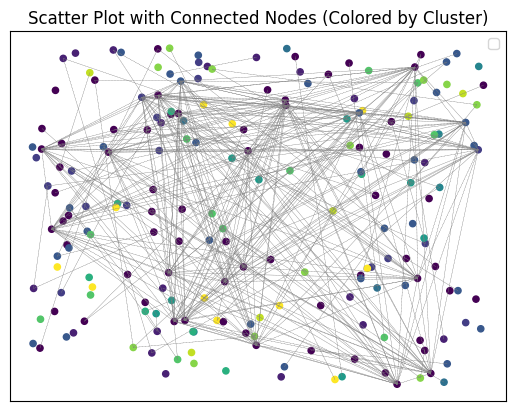

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, squareform

# Create a random scatter plot with colored nodes based on cluster
x = np.random.rand(len(df))
y = np.random.rand(len(df))

plt.scatter(x, y, s=20, c=df['cluster'], cmap='viridis')

# Calculate pairwise differences in predicted probabilities
prob_diff = pdist(df['PredictedProb'].values.reshape(-1, 1))

# Connect nodes with probability difference less than 0.1 with reduced line thickness
pairs_to_connect = np.argwhere(squareform(prob_diff) < 0.001)

for pair in pairs_to_connect:
    plt.plot([x[pair[0]], x[pair[1]]], [y[pair[0]], y[pair[1]]], color='gray', linestyle='--', linewidth=0.2)


plt.xticks([])
plt.yticks([])

plt.title('Scatter Plot with Connected Nodes (Colored by Cluster)')
plt.legend()
plt.show()


In [15]:
from Utils import predictor, retrainer
df_socio.update(df_socio[['tweet']].applymap('\'{}\''.format))
clean_df_socio=clean_tweets(df_socio)
X=clean_df_socio['tweet']


In [ ]:
X=